### Compare new Rioseq with previous Riboseq

#### 1. P site offset comparison
Ribosome usually protects around 30 nts of mRNA sequence, P-site reflects which AA that ribosome is translating. When getting the position of mapped reads, usually we use 5' end or sometime 3'end of the read to indicate where does the read maps to the genome. In Riboseq, the 5'/3' end represents the boundary of the ribosome, but the p site is in the middle of ribosome. Therefore, to know which position in the mapping read corresponds to the ribosome's P site, we need to calculate how far is the 5'/3' end to the P site, which is called P-site offset.

First of all, let's look at the mapping length distribution. From the figure we can see that the new method has longer read length than old ones. This is mainly because the new method uses MNase which doesn't degrade nucleotides as neatly as RNase.

In [72]:
import pandas as pd
import matplotlib.pyplot as plt
plt.style.use('ggplot')
%matplotlib inline 

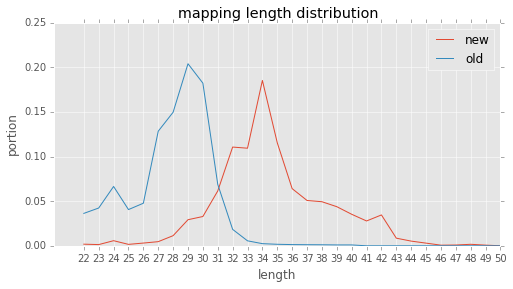

In [3]:
# read in data
len_range = range(22,51)
new_cov_fn = '/data/shangzhong/RibosomeProfiling/ritux/02_cov/tri_cov.txt'
old_cov_fn = '/data/shangzhong/RibosomeProfiling/ritux/previous_data/02_cov/s06_cov.txt'
new_df = pd.read_csv(new_cov_fn,sep='\t',header=0,usecols=[0,5],names=['count','len'])
new_len_count = new_df.groupby('len').sum()
old_df = pd.read_csv(old_cov_fn,sep='\t',header=0,usecols=[0,5],names=['count','len'])
old_len_count = old_df.groupby('len').sum()
# get count at each length
new_c = []
old_c = []
for l in len_range:
    try:
        new_c.append(new_len_count.loc[l,'count'])
    except:
        new_c.append(0)
    try:
        old_c.append(old_len_count.loc[l,'count'])
    except:
        old_c.append(0)
new_total = sum(new_c)
old_total = sum(old_c)
new_cov = [float(p)/new_total for p in new_c]
old_cov = [float(p)/old_total for p in old_c]
# plot data
fig = plt.subplots(figsize=(8,4))
_ = plt.plot(len_range,new_cov,label='new')
_ = plt.plot(len_range,old_cov,label='old')
_ = plt.xticks(len_range)
_ = plt.legend()
_ = plt.title('mapping length distribution')
_ = plt.xlabel('length')
_ = plt.ylabel('portion')

Then we can check the P site offset for each mapping length. 
1) For previous Riboseq that uses RNase, using 5'end to calculate the offset is better. The following figures are coverage 50 bps upstream and downstream of TSS for each mapping length. 0 position represents the first base pair of the start codon. Here I summed read counts for all the genes in the correspondign position.

![title](com_old_new_ribo/old_tss5_batch0.png)
![title](com_old_new_ribo/old_tss5_batch1.png)
For most of the mapping lengths, we can see a very high peak upstream of position 0. The distance between the peak and 0 indicates the distance between 5'end of ribosome and start of P site. The distance are mainly 12,13 in the old data. If we overlay all the lengths into one figure, it's even more clear and at the same time we see the 3 nt periodic coverage.
![title](com_old_new_ribo/old_tss5.png)

2) The new riboseq data uses MNase. After talking with some people who applied MNase to bacteria, they suggested to use 3'end of the reads to get the position because it performs better than 5'end. From the previous length distribution file, we can see that the new datasets has longer mapping length, so we consider longer reads for the new datasets. The following are coverage around TSS in new ribo data.
![title](com_old_new_ribo/tss3_batch0.png)
![title](com_old_new_ribo/tss3_batch1.png)
![title](com_old_new_ribo/tss3_batch2.png)
From the above figure we can see that in the downstream of TSS, many have two peaks. Based on the fact that the offset should be short than read length, we choose the closer one. So for lengths smaller than 37, the offset is 14, for lengths larger than 37 the offset is 27. If we overlay all the lengths into one figure, we see weak 3 nt periodic coverage.
![title](com_old_new_ribo/tss3.png)

#### 2. Coverage comparison in cds, utr and other regions.
The more reads mapping to the coding regions, the better the protocal is. So next we comapre the how many percentage of reads mapping to CDS, 5'UTR, 3'UTR and other parts of the genome.

In [273]:
# get count percentage old data
old_cov_fn = '/data/shangzhong/RibosomeProfiling/ritux/previous_data/02_cov/s06_cov.txt'
old_cov_df = pd.read_csv(old_cov_fn,sep='\t',usecols=[0],names=['count'])
old_total = old_cov_df['count'].sum()
old_fn = '/data/shangzhong/RibosomeProfiling/ritux/previous_data/05_cds_utr_count/s06_cov.txt'
old_df = pd.read_csv(old_fn,sep='\t',header=0,index_col=0)
old_count = old_df.sum().div(old_total)
old_count['other'] = 1 - sum(old_count)
# get count percentage for new data
new_cov_fn = '/data/shangzhong/RibosomeProfiling/ritux/02_cov/tri_cov.txt'
new_cov_df = pd.read_csv(new_cov_fn,sep='\t',usecols=[0],names=['count'])
new_total = new_cov_df['count'].sum()
new_fn = '/data/shangzhong/RibosomeProfiling/ritux/05_cds_utr_count/tri_cov.txt'
new_df = pd.read_csv(new_fn,sep='\t',header=0,index_col=0)
new_count = new_df.sum().div(new_total)
new_gene_count_fn = '/data/shangzhong/RibosomeProfiling/ritux/06_gene_intron_count/tri_cov.txt'
new_gene_count_df= pd.read_csv(new_gene_count_fn,sep='\t',header=0,index_col=0)
new_gene_total = new_gene_count_df.sum().div(new_total)
new_count = new_count.append(new_gene_total)
new_count['other'] = 1 - sum(new_count)
# plot
df = pd.DataFrame()
df['old'] = old_count
df['new'] = new_count
df.index = ['cds','utr5','utr3','other']

In [277]:
new_count
old_count

cds_count     0.504252
utr5_count    0.063515
utr3_count    0.006874
other         0.425359
dtype: float64

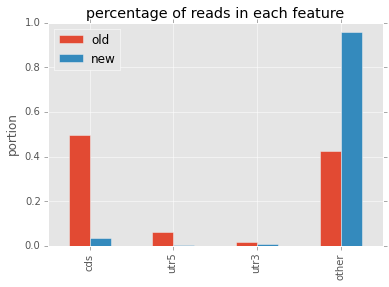

In [80]:
ax = df.plot(kind='bar',title='percentage of reads in each feature')
_ = ax.set_ylabel('portion')

The above figure shows that the new data only has very little portion of reads mapping to the coding regions compared to the old data. The old data has half reads mapping to the CDS, it's mainly because I only filtered reads mapping to rRNA, but it also has many reads mapping to tRNA. The table below shows the percentage of reads mapping to each feature.

This is just rough calculation, becuase I used the htseqcount to get the data, not considering the offset. But the scale is in the right order.
| feature(%) | new | old |
|------------|-----|-----|
| CDS        | 3.7 | 50  |
| UTR        | 0.8 | 7   |
| intron     | 11  | 0.6 |
| intergenic | 26.5| 37  |
| trna       | 58  | 12  |

** In the new datasets, the tRNA occupies about 58% of the total reads,which is much higher than the old data (12%). This means the new protocol failed to remove most of the trna. **


In [2]:
%reload_ext autoreload
%autoreload 2